In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mplcol
import functions as func
import importlib

### ACD centers, shapes and indices

In [2]:
# Training segments
mydf_train, indices_train = func.getACD_df(outlier_threshold=2.5, DQ='h')
cxx_train, cyy_train = func.getCentroids(indices=indices_train) 
mydf_ex_train, indices_ex_train = func.getACD_df(outlier_threshold=2.5, DQ='hm', extreme=True)
cxx_ex_train, cyy_ex_train = func.getCentroids(indices=indices_ex_train)

# All segments (forcing)
mydf_force, indices_force = func.getACD_df(outlier_threshold=2.5, DQ='all')
cxx_force, cyy_force = func.getCentroids(indices=indices_force) 
mydf_ex_force, indices_ex_force = func.getACD_df(outlier_threshold=2.5, DQ='all', extreme=True)

cxx_ex_force, cyy_ex_force = func.getCentroids(indices=indices_ex_force)
cxx_force_all = np.hstack([cxx_force, cxx_ex_force])
cyy_force_all = np.hstack([cyy_force, cyy_ex_force])
cat_idcs = np.hstack([indices_force, indices_ex_force,])

importlib.reload(func)
shape_feature = func.segments()

### Erosion rate projections

In [3]:
ipath="DKRZ_DOKU/"
scenstr="ssp585"
ifile="eros_ACD-segments_"+scenstr+"_q0.50.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros = ds['eros'].values
seg = ds['seg'].values
time = ds['time'].values

### Separate Roger's region

In [4]:
my_lons = np.where((cxx_force_all>-160) & (cxx_force_all<-145), cxx_force_all, np.nan)
my_lats = np.where((cxx_force_all>-160) & (cxx_force_all<-145), cyy_force_all, np.nan)
my_eros = np.where((cxx_force_all>-160) & (cxx_force_all<-145), eros, np.nan)
my_idcs =np.where((cxx_force_all>-160) & (cxx_force_all<-145), cat_idcs, np.nan)
npoints = len(my_lons[~np.isnan(my_lons)])

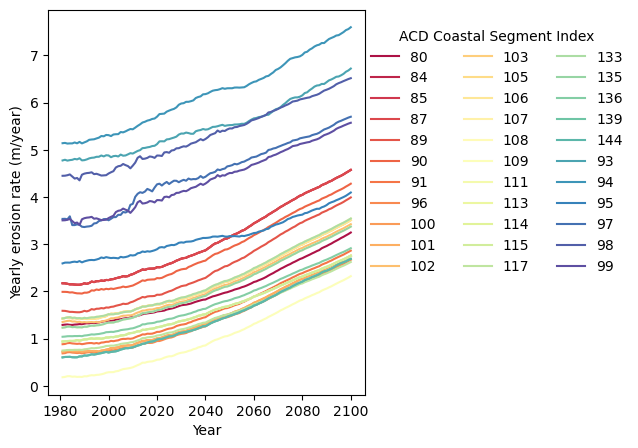

In [5]:
fig = plt.figure(figsize=(9,5))

cmap = cm.get_cmap('Spectral')
ax = fig.add_subplot(121)
c=0
for i in range(len(my_lons)):
    if ~np.isnan(my_lons[i]):
        c=c+1
        plt.plot(time[-120:], my_eros[-120:,i], label=int(my_idcs[i]), c=cmap(c/npoints))
plt.legend(ncol=3, title='ACD Coastal Segment Index', frameon=False, loc=(1,0.3))
plt.ylabel('Yearly erosion rate (m/year)')
plt.xlabel('Year')
plt.show()


## Figures

In [6]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.mpl.ticker as cticker


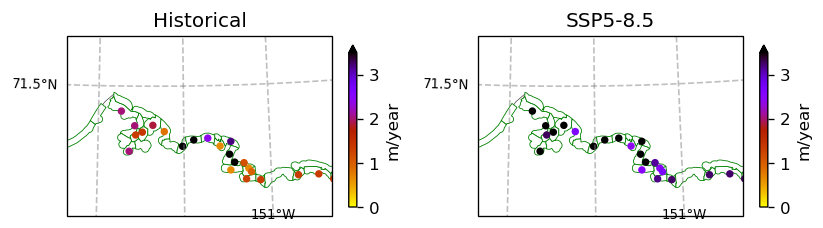

In [7]:
fig = plt.figure(figsize=(7, 3), dpi=120)
proj=ccrs.cartopy.crs.LambertConformal(central_longitude=-155.0, central_latitude=39.0, false_easting=0.0, 
                                       false_northing=0.0, 
                                       globe=None, cutoff=-30)

s=20
fontsize=8
vmax=3.5
vmin=0
res='50m'
lw=0.5

# make means
eros_hist = np.mean(eros[:100,:], axis=0)
eros_s585 = np.mean(eros[-20:,:], axis=0)


ax = fig.add_subplot(121,projection=proj)
ax.set_extent([-158, -149, 70, 72], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(my_lons,my_lats, c=eros_hist, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')
ax.add_feature(shape_feature, facecolor='w',edgecolor='g', linewidth=lw)
plt.colorbar(m, shrink=0.5, extend='max', label='m/year')
plt.title('Historical')

gl = ax.gridlines(crs=ccrs.PlateCarree(), lw=1, color='grey', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlines        = True
gl.ylines        = True
gl.top_labels    = True
gl.bottom_labels = True
gl.left_labels   = True
gl.right_labels  = False
gl.xlocator = mticker.FixedLocator([-157, -154, -151])
gl.ylocator = mticker.FixedLocator([71.5])
gl.ylabel_style = {'fontsize':8}
gl.xlabel_style = {'fontsize':8}

ax = fig.add_subplot(122,projection=proj)
ax.set_extent([-158, -149, 70, 72], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(my_lons,my_lats, c=eros_s585, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')
ax.add_feature(shape_feature, facecolor='w',edgecolor='g', linewidth=lw)
plt.colorbar(m, shrink=0.5, extend='max', label='m/year')
plt.title('SSP5-8.5')

gl = ax.gridlines(crs=ccrs.PlateCarree(), lw=1, color='grey', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlines        = True
gl.ylines        = True
gl.top_labels    = True
gl.bottom_labels = True
gl.left_labels   = True
gl.right_labels  = False
gl.xlocator = mticker.FixedLocator([-157, -154, -151])
gl.ylocator = mticker.FixedLocator([71.5])
gl.ylabel_style = {'fontsize':8}
gl.xlabel_style = {'fontsize':8}


plt.tight_layout()
plt.show()


#### Save data

In [8]:
eros.shape

(232, 306)

In [9]:
time.shape

(232,)

In [10]:
newds = xr.Dataset(data_vars={'seg':  (["seg"], my_idcs),
                              'time':(["time"], time),
                              'eros': (["time","seg"], eros),
                              'lon': (["lon"], my_lons),
                              'lat': (["lat"], my_lats),
                             })
newds['seg'].attrs  = {'standard_name':'seg', 'units':'-', 'comment':'coastal segment identifier from the ACD'}
newds['time'].attrs = {'standard_name':'time',  'units':'year'}
newds['eros'].attrs = {'standard_name':'eros', 'units':'m/year'}
newds['lon'].attrs  = {'standard_name':'lon', 'units':'deg. East'}
newds['lon'].attrs  = {'standard_name':'lat', 'units':'deg. North'}
newds.attrs = {'script' :'https://github.com/davidmnielsen/Nielsen-etal_2022_ArcticCoastalErosion/blob/main/Data4Roger.ipynb'}
newds.to_netcdf('/work/mh0727/m300689/Nielsen-etal_2022_ArcticCoastalErosion/roger.nc')